# 低価格帯・築年数の詳細分析

## 目的
- 低価格帯（~1000万円）の予測誤差が大きい原因を分析
- 築年数の非線形性を確認
- 改善策を検討

In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parents[2]
sys.path.insert(0, str(project_root / "04_src"))

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

# 出力ディレクトリ
output_dir = Path.cwd().parent / "outputs"
notebook_output = Path.cwd() / "figures"
notebook_output.mkdir(exist_ok=True)

print(f"Project root: {project_root}")

Project root: /Users/kotaro/Desktop/ML/20251122_signamte_mlit


## 1. データ読み込み

In [2]:
# 訓練データ
train = pl.read_csv(project_root / "data" / "raw" / "train.csv", infer_schema_length=100000)
print(f"訓練データ: {train.shape}")

# エリアマスター
area_master = pl.read_csv(project_root / "data" / "master" / "area_master.csv")
area_master = area_master.with_columns([
    pl.col("addr1_1").cast(pl.Int64),
    pl.col("addr1_2").cast(pl.Int64),
])
print(f"エリアマスター: {area_master.shape}")

# OOF予測読み込み
oof_files = sorted(output_dir.glob("oof_predictions_*.csv"))
latest_oof = oof_files[-1] if oof_files else None
print(f"OOF file: {latest_oof}")

oof_df = pl.read_csv(latest_oof)
oof_df = oof_df.with_columns([
    ((pl.col("predicted") - pl.col("actual")).abs() / pl.col("actual") * 100).alias("ape"),
    (pl.col("predicted") - pl.col("actual")).alias("error"),
])
print(f"OOF予測: {oof_df.shape}")

訓練データ: (363924, 149)
エリアマスター: (1953, 5)
OOF file: /Users/kotaro/Desktop/ML/20251122_signamte_mlit/06_experiments/exp003_baseline_v2/outputs/oof_predictions_20251125_133509.csv
OOF予測: (363924, 5)


In [3]:
# 訓練データとOOF予測を結合
train_with_oof = train.with_row_index("row_id").join(
    oof_df.rename({"id": "row_id"}),
    on="row_id",
    how="left"
)

# エリア情報を結合
train_with_oof = train_with_oof.with_columns([
    pl.col("addr1_1").cast(pl.Int64),
    pl.col("addr1_2").cast(pl.Int64),
])
train_with_area = train_with_oof.join(
    area_master.select(["addr1_1", "addr1_2", "都道府県名", "市区町村名"]),
    on=["addr1_1", "addr1_2"],
    how="left"
)

print(f"結合後データ: {train_with_area.shape}")

結合後データ: (363924, 156)


## 2. 価格帯別の基本分析

In [4]:
# 価格帯で分割
low_price = train_with_oof.filter(pl.col("actual") < 10_000_000)
mid_price = train_with_oof.filter((pl.col("actual") >= 10_000_000) & (pl.col("actual") < 30_000_000))
high_price = train_with_oof.filter(pl.col("actual") >= 30_000_000)

print("=" * 70)
print("低価格帯（~1000万円）の特徴分析")
print("=" * 70)

print(f"\n【サンプル数】")
print(f"  低価格帯 (~1000万): {len(low_price):,} ({len(low_price)/len(train)*100:.1f}%)")
print(f"  中価格帯 (1000-3000万): {len(mid_price):,} ({len(mid_price)/len(train)*100:.1f}%)")
print(f"  高価格帯 (3000万~): {len(high_price):,} ({len(high_price)/len(train)*100:.1f}%)")

低価格帯（~1000万円）の特徴分析

【サンプル数】
  低価格帯 (~1000万): 48,356 (13.3%)
  中価格帯 (1000-3000万): 214,191 (58.9%)
  高価格帯 (3000万~): 101,377 (27.9%)


In [5]:
# 築年数比較
print(f"【築年数 (year_built)】")
for name, df in [("低価格", low_price), ("中価格", mid_price), ("高価格", high_price)]:
    year_built = df["year_built"].drop_nulls()
    if len(year_built) > 0:
        years = (year_built // 100).to_numpy()
        ages = 2024 - years
        print(f"  {name}: 平均築{ages.mean():.1f}年, 中央値{np.median(ages):.1f}年")

【築年数 (year_built)】
  低価格: 平均築41.2年, 中央値41.0年
  中価格: 平均築31.6年, 中央値31.0年
  高価格: 平均築23.4年, 中央値21.0年


In [6]:
# 面積比較
print(f"【専有面積 (house_area)】")
for name, df in [("低価格", low_price), ("中価格", mid_price), ("高価格", high_price)]:
    area = df["house_area"].drop_nulls().to_numpy()
    print(f"  {name}: 平均{area.mean():.1f}㎡, 中央値{np.median(area):.1f}㎡")

【専有面積 (house_area)】
  低価格: 平均74.1㎡, 中央値70.2㎡
  中価格: 平均91.3㎡, 中央値79.5㎡
  高価格: 平均96.1㎡, 中央値81.2㎡


In [7]:
# 都道府県分布
print(f"【都道府県分布（低価格帯の上位10）】")
low_pref = low_price.group_by("addr1_1").agg(pl.len().alias("count")).sort("count", descending=True)
low_pref = low_pref.with_columns(pl.col("addr1_1").cast(pl.Int64)).join(
    area_master.select(["addr1_1", "都道府県名"]).unique(),
    on="addr1_1",
    how="left"
)
for row in low_pref.head(10).iter_rows(named=True):
    pct = row["count"] / len(low_price) * 100
    print(f"  {row['都道府県名']}: {row['count']:,} ({pct:.1f}%)")

【都道府県分布（低価格帯の上位10）】
  大阪府: 6,885 (14.2%)
  兵庫県: 4,373 (9.0%)
  千葉県: 4,228 (8.7%)
  埼玉県: 4,101 (8.5%)
  神奈川県: 3,256 (6.7%)
  福岡県: 2,686 (5.6%)
  京都府: 2,256 (4.7%)
  東京都: 2,250 (4.7%)
  愛知県: 2,095 (4.3%)
  静岡県: 1,806 (3.7%)


In [8]:
# 物件タイプ
print(f"【物件タイプ (bukken_type)】")
for name, df in [("低価格", low_price), ("中価格", mid_price), ("高価格", high_price)]:
    type_dist = df.group_by("bukken_type").agg(pl.len().alias("count"))
    type_dist = type_dist.with_columns((pl.col("count") / pl.col("count").sum() * 100).alias("pct"))
    type_str = ", ".join([f"type{int(r['bukken_type'])}:{r['pct']:.1f}%" for r in type_dist.iter_rows(named=True)])
    print(f"  {name}: {type_str}")

【物件タイプ (bukken_type)】
  低価格: type1202:54.0%, type1302:46.0%
  中価格: type1202:46.8%, type1302:53.2%
  高価格: type1302:61.6%, type1202:38.4%


## 3. 低価格帯の予測誤差パターン分析

In [9]:
print("=" * 70)
print("低価格帯の予測誤差パターン分析")
print("=" * 70)

# 予測方向（過大予測 vs 過小予測）
over_pred = low_price.filter(pl.col("error") > 0)
under_pred = low_price.filter(pl.col("error") < 0)
print(f"\n【予測方向】")
print(f"  過大予測: {len(over_pred):,} ({len(over_pred)/len(low_price)*100:.1f}%)")
print(f"  過小予測: {len(under_pred):,} ({len(under_pred)/len(low_price)*100:.1f}%)")
print(f"  過大予測の平均誤差: +{over_pred['error'].mean():,.0f}円")
print(f"  過小予測の平均誤差: {under_pred['error'].mean():,.0f}円")

低価格帯の予測誤差パターン分析

【予測方向】
  過大予測: 47,299 (97.8%)
  過小予測: 1,057 (2.2%)
  過大予測の平均誤差: +5,262,440円
  過小予測の平均誤差: -619,473円


In [10]:
# 低価格帯の詳細価格帯別
print(f"【低価格帯の詳細分析】")
for lower, upper, label in [(0, 3_000_000, "~300万"), 
                             (3_000_000, 5_000_000, "300-500万"),
                             (5_000_000, 7_000_000, "500-700万"),
                             (7_000_000, 10_000_000, "700-1000万")]:
    subset = low_price.filter((pl.col("actual") >= lower) & (pl.col("actual") < upper))
    if len(subset) > 0:
        mean_ape = subset["ape"].mean()
        over_pct = len(subset.filter(pl.col("error") > 0)) / len(subset) * 100
        mean_pred = subset["predicted"].mean()
        mean_actual = subset["actual"].mean()
        print(f"  {label}: n={len(subset):,}, APE={mean_ape:.1f}%, 過大予測率={over_pct:.1f}%")
        print(f"         実測平均={mean_actual:,.0f}円, 予測平均={mean_pred:,.0f}円")

【低価格帯の詳細分析】
  300-500万: n=1,290, APE=129.9%, 過大予測率=100.0%
         実測平均=4,925,335円, 予測平均=11,323,863円
  500-700万: n=16,294, APE=94.7%, 過大予測率=100.0%
         実測平均=6,083,703円, 予測平均=11,761,284円
  700-1000万: n=30,772, APE=56.5%, 過大予測率=96.6%
         実測平均=8,709,814円, 予測平均=13,502,767円


In [11]:
# 築年数との関係
print(f"【低価格帯 × 築年数】")
low_price_with_age = low_price.with_columns([
    (2024 - (pl.col("year_built") // 100)).alias("age")
])
for age_lower, age_upper, label in [(0, 20, "築20年未満"), 
                                     (20, 30, "築20-30年"),
                                     (30, 40, "築30-40年"),
                                     (40, 100, "築40年以上")]:
    subset = low_price_with_age.filter((pl.col("age") >= age_lower) & (pl.col("age") < age_upper))
    if len(subset) > 0:
        mean_ape = subset["ape"].mean()
        print(f"  {label}: n={len(subset):,}, APE={mean_ape:.1f}%")

【低価格帯 × 築年数】
  築20年未満: n=903, APE=145.5%


  築20-30年: n=3,743, APE=85.4%
  築30-40年: n=15,826, APE=64.5%
  築40年以上: n=25,791, APE=66.3%


In [12]:
# 面積との関係
print(f"【低価格帯 × 面積】")
for area_lower, area_upper, label in [(0, 30, "~30㎡"), 
                                       (30, 50, "30-50㎡"),
                                       (50, 70, "50-70㎡"),
                                       (70, 100, "70-100㎡"),
                                       (100, 10000, "100㎡~")]:
    subset = low_price.filter((pl.col("house_area") >= area_lower) & (pl.col("house_area") < area_upper))
    if len(subset) > 0:
        mean_ape = subset["ape"].mean()
        print(f"  {label}: n={len(subset):,}, APE={mean_ape:.1f}%")

【低価格帯 × 面積】
  ~30㎡: n=4,818, APE=47.7%
  30-50㎡: n=4,832, APE=59.4%
  50-70㎡: n=14,257, APE=65.5%


  70-100㎡: n=16,100, APE=72.1%
  100㎡~: n=8,349, APE=100.4%


In [13]:
# 外れ値的な物件の特徴
print(f"【超高APE（>200%）の低価格帯物件】")
extreme_errors = low_price.filter(pl.col("ape") > 200)
print(f"  件数: {len(extreme_errors):,} ({len(extreme_errors)/len(low_price)*100:.1f}%)")
if len(extreme_errors) > 0:
    print(f"  平均面積: {extreme_errors['house_area'].mean():.1f}㎡")
    year_built = extreme_errors["year_built"].drop_nulls()
    if len(year_built) > 0:
        ages = 2024 - (year_built // 100).to_numpy()
        print(f"  平均築年数: {ages.mean():.1f}年")
    print(f"  平均実測価格: {extreme_errors['actual'].mean():,.0f}円")
    print(f"  平均予測価格: {extreme_errors['predicted'].mean():,.0f}円")

【超高APE（>200%）の低価格帯物件】
  件数: 1,232 (2.5%)
  平均面積: 149.7㎡
  平均築年数: 41.2年
  平均実測価格: 6,371,489円
  平均予測価格: 23,285,886円


## 4. 築年数と価格・APEの関係

In [14]:
# 築年数を追加（nullを除外）
train_with_age = train_with_oof.filter(pl.col("year_built").is_not_null()).with_columns([
    (2024 - (pl.col("year_built") // 100)).alias("building_age")
])

print("=" * 70)
print("築年数と価格・APEの関係")
print("=" * 70)

築年数と価格・APEの関係


In [15]:
# 築年数帯 × 価格帯のクロス分析
print("\n【築年数帯 × 価格帯のクロス分析】")
print("        | ~1000万 | 1000-3000万 | 3000万~ ")
print("-" * 55)

for age_lower, age_upper, label in [(0, 10, "~10年"),
                                     (10, 20, "10-20年"),
                                     (20, 30, "20-30年"),
                                     (30, 40, "30-40年"),
                                     (40, 50, "40-50年"),
                                     (50, 100, "50年~")]:
    age_subset = train_with_age.filter((pl.col("building_age") >= age_lower) & (pl.col("building_age") < age_upper))
    
    low = age_subset.filter(pl.col("actual") < 10_000_000)
    mid = age_subset.filter((pl.col("actual") >= 10_000_000) & (pl.col("actual") < 30_000_000))
    high = age_subset.filter(pl.col("actual") >= 30_000_000)
    
    low_pct = len(low) / len(age_subset) * 100 if len(age_subset) > 0 else 0
    mid_pct = len(mid) / len(age_subset) * 100 if len(age_subset) > 0 else 0
    high_pct = len(high) / len(age_subset) * 100 if len(age_subset) > 0 else 0
    
    print(f"{label:8} | {low_pct:5.1f}%   | {mid_pct:7.1f}%    | {high_pct:5.1f}%")


【築年数帯 × 価格帯のクロス分析】
        | ~1000万 | 1000-3000万 | 3000万~ 
-------------------------------------------------------


~10年     |   2.3%   |    35.7%    |  62.0%
10-20年   |   0.5%   |    54.7%    |  44.9%


20-30年   |   4.4%   |    62.9%    |  32.6%
30-40年   |  20.2%   |    65.1%    |  14.7%


40-50年   |  23.2%   |    62.8%    |  14.0%
50年~     |  30.0%   |    55.5%    |  14.5%


In [16]:
# 築年数と平均賃料の関係
print("\n【築年数と平均賃料の関係】")
age_price = train_with_age.group_by(
    (pl.col("building_age") // 5 * 5).alias("age_bin")
).agg([
    pl.col("money_room").mean().alias("avg_price"),
    pl.len().alias("count"),
]).sort("age_bin").filter(pl.col("count") > 100)

for row in age_price.iter_rows(named=True):
    age_bin = row['age_bin']
    if age_bin is not None:
        bar = "█" * int(row["avg_price"] / 500000)
        print(f"  {int(age_bin):2d}-{int(age_bin)+5:2d}年: {row['avg_price']:,.0f}円 {bar}")


【築年数と平均賃料の関係】


  -5- 0年: 28,865,394円 █████████████████████████████████████████████████████████
   0- 5年: 31,933,525円 ███████████████████████████████████████████████████████████████
   5-10年: 40,340,501円 ████████████████████████████████████████████████████████████████████████████████
  10-15年: 36,926,652円 █████████████████████████████████████████████████████████████████████████
  15-20年: 32,510,546円 █████████████████████████████████████████████████████████████████
  20-25年: 31,969,851円 ███████████████████████████████████████████████████████████████
  25-30年: 26,106,370円 ████████████████████████████████████████████████████
  30-35年: 20,504,874円 █████████████████████████████████████████
  35-40年: 20,348,051円 ████████████████████████████████████████
  40-45年: 20,389,640円 ████████████████████████████████████████
  45-50年: 18,449,006円 ████████████████████████████████████
  50-55年: 18,493,167円 ████████████████████████████████████
  55-60年: 19,664,925円 ███████████████████████████████████████
  60-65年: 19,399

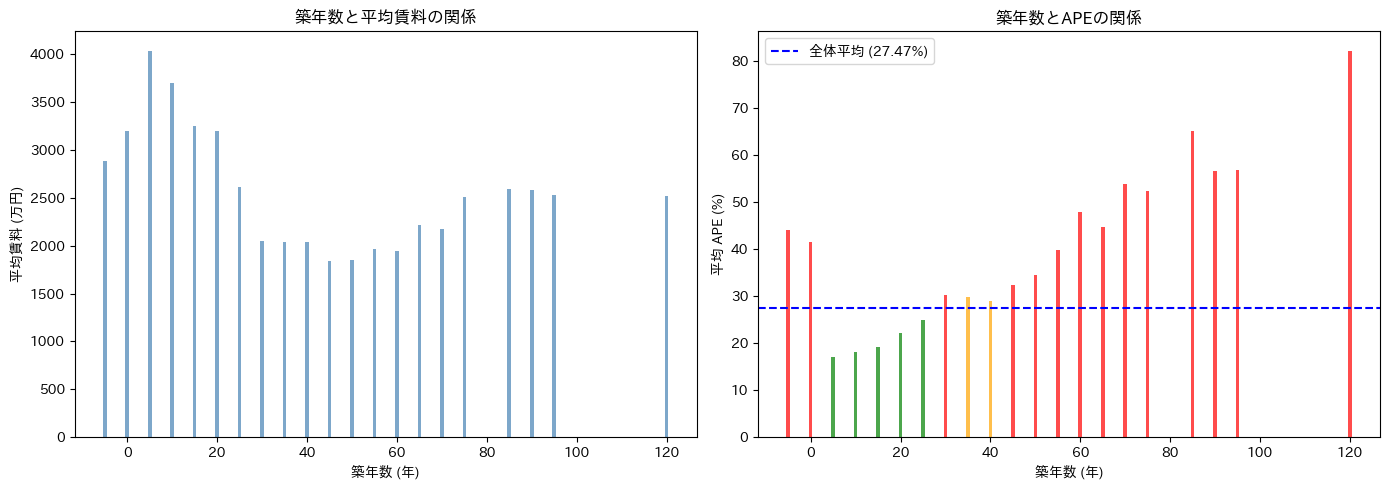

In [17]:
# 築年数 vs APE（可視化）
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左: 築年数 vs 平均賃料
ax = axes[0]
age_bins = [row['age_bin'] for row in age_price.iter_rows(named=True) if row['age_bin'] is not None]
avg_prices = [row['avg_price'] for row in age_price.iter_rows(named=True) if row['age_bin'] is not None]
ax.bar(age_bins, np.array(avg_prices) / 10000, color='steelblue', alpha=0.7)
ax.set_xlabel("築年数 (年)")
ax.set_ylabel("平均賃料 (万円)")
ax.set_title("築年数と平均賃料の関係")

# 右: 築年数 vs APE
ax = axes[1]
age_ape = train_with_age.group_by(
    (pl.col("building_age") // 5 * 5).alias("age_bin")
).agg([
    pl.col("ape").mean().alias("avg_ape"),
    pl.len().alias("count"),
]).sort("age_bin").filter(pl.col("count") > 100)

age_bins_ape = [row['age_bin'] for row in age_ape.iter_rows(named=True) if row['age_bin'] is not None]
avg_apes = [row['avg_ape'] for row in age_ape.iter_rows(named=True) if row['age_bin'] is not None]
colors = ['red' if ape > 30 else 'orange' if ape > 25 else 'green' for ape in avg_apes]
ax.bar(age_bins_ape, avg_apes, color=colors, alpha=0.7)
ax.axhline(27.47, color='blue', linestyle='--', label='全体平均 (27.47%)')
ax.set_xlabel("築年数 (年)")
ax.set_ylabel("平均 APE (%)")
ax.set_title("築年数とAPEの関係")
ax.legend()

plt.tight_layout()
plt.savefig(notebook_output / "age_price_ape.png", dpi=150, bbox_inches='tight')
plt.show()

In [18]:
# 築年数 vs APE（テキスト出力）
print("\n【築年数 vs APE（全データ）】")
for row in age_ape.iter_rows(named=True):
    age_bin = row['age_bin']
    if age_bin is not None:
        bar = "█" * int(row["avg_ape"] / 2)
        print(f"  {int(age_bin):2d}-{int(age_bin)+5:2d}年: {row['avg_ape']:.1f}% {bar}")


【築年数 vs APE（全データ）】
  -5- 0年: 44.0% ██████████████████████
   0- 5年: 41.6% ████████████████████
   5-10年: 17.2% ████████
  10-15年: 18.2% █████████
  15-20年: 19.3% █████████
  20-25年: 22.2% ███████████
  25-30年: 24.9% ████████████
  30-35年: 30.2% ███████████████
  35-40年: 29.8% ██████████████
  40-45年: 28.9% ██████████████
  45-50年: 32.4% ████████████████
  50-55年: 34.4% █████████████████
  55-60年: 39.8% ███████████████████
  60-65年: 47.9% ███████████████████████
  65-70年: 44.7% ██████████████████████
  70-75年: 53.9% ██████████████████████████
  75-80年: 52.4% ██████████████████████████
  85-90年: 65.0% ████████████████████████████████
  90-95年: 56.6% ████████████████████████████
  95-100年: 56.9% ████████████████████████████
  120-125年: 82.2% █████████████████████████████████████████


## 5. 築年数と賃料の相関分析

In [19]:
# 相関を計算
ages = train_with_age["building_age"].to_numpy()
prices = train_with_age["money_room"].to_numpy()

# 負の築年数を除外
valid_mask = ages > 0
ages_valid = ages[valid_mask]
prices_valid = prices[valid_mask]

print("【築年数と賃料の相関】")
print(f"  線形 (age): {np.corrcoef(ages_valid, prices_valid)[0,1]:.4f}")
print(f"  2乗 (age^2): {np.corrcoef(ages_valid**2, prices_valid)[0,1]:.4f}")
print(f"  log (log(age+1)): {np.corrcoef(np.log(ages_valid+1), prices_valid)[0,1]:.4f}")
print(f"  sqrt (sqrt(age)): {np.corrcoef(np.sqrt(ages_valid), prices_valid)[0,1]:.4f}")

【築年数と賃料の相関】
  線形 (age): -0.3341
  2乗 (age^2): -0.1992
  log (log(age+1)): -0.3404
  sqrt (sqrt(age)): -0.3477


## 6. 面積単価の分析

In [20]:
print("【面積単価 (money_room / house_area) の分析】")
train_with_unit = train_with_age.filter(pl.col("house_area") > 0).with_columns([
    (pl.col("money_room") / pl.col("house_area")).alias("unit_price")
])

low_unit = train_with_unit.filter(pl.col("actual") < 10_000_000)
mid_unit = train_with_unit.filter((pl.col("actual") >= 10_000_000) & (pl.col("actual") < 30_000_000))
high_unit = train_with_unit.filter(pl.col("actual") >= 30_000_000)

print(f"  低価格帯: 平均単価 {low_unit['unit_price'].mean():,.0f}円/㎡")
print(f"  中価格帯: 平均単価 {mid_unit['unit_price'].mean():,.0f}円/㎡")
print(f"  高価格帯: 平均単価 {high_unit['unit_price'].mean():,.0f}円/㎡")

【面積単価 (money_room / house_area) の分析】


  低価格帯: 平均単価 138,940円/㎡
  中価格帯: 平均単価 274,430円/㎡
  高価格帯: 平均単価 584,249円/㎡


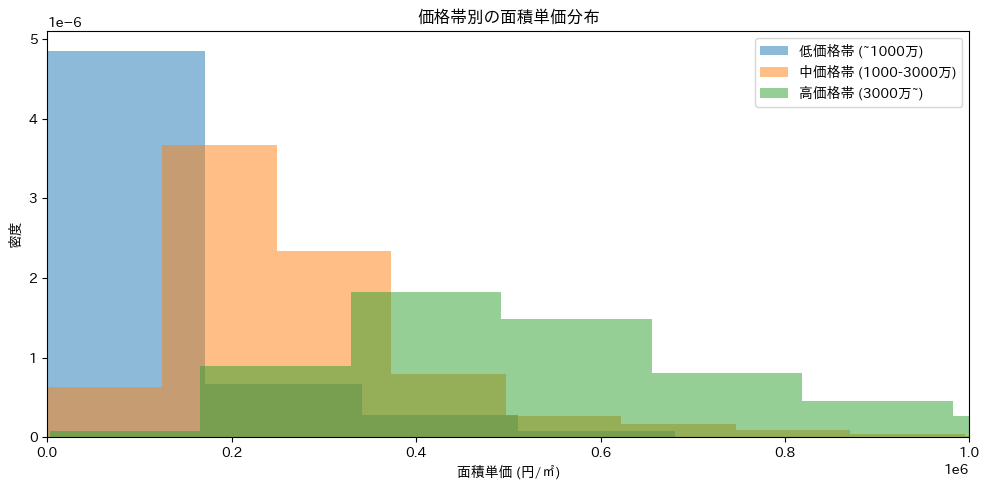

In [21]:
# 面積単価の分布を可視化
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(low_unit["unit_price"].to_numpy(), bins=50, alpha=0.5, label="低価格帯 (~1000万)", density=True)
ax.hist(mid_unit["unit_price"].to_numpy(), bins=50, alpha=0.5, label="中価格帯 (1000-3000万)", density=True)
ax.hist(high_unit["unit_price"].to_numpy(), bins=50, alpha=0.5, label="高価格帯 (3000万~)", density=True)

ax.set_xlabel("面積単価 (円/㎡)")
ax.set_ylabel("密度")
ax.set_title("価格帯別の面積単価分布")
ax.set_xlim(0, 1_000_000)
ax.legend()

plt.tight_layout()
plt.savefig(notebook_output / "unit_price_distribution.png", dpi=150, bbox_inches='tight')
plt.show()

## 7. サマリーと改善策

In [22]:
print("=" * 70)
print("分析サマリー")
print("=" * 70)

print("""
【低価格帯の問題の本質】
  - 低価格帯（~1000万円）の 97.8% が過大予測
  - 特に500-700万の物件: APE 94.7%, 過大予測率 100%
  - モデルは「安い物件を高く見積もりすぎる」傾向

【低価格帯の特徴】
  - 築年数: 平均41.2年（古い物件が多い）
  - 面積単価: 138,940円/㎡（中価格帯の半分以下）
  - 築40年以上の物件が低価格帯の約53%を占める

【築年数の影響】
  - 5-10年: APE 17.2%（最も予測しやすい）
  - 30-40年: APE 29.8%（悪化開始）
  - 50年以上: APE 34-82%（大幅悪化）
  - 築年数と賃料の相関: -0.33（古いほど安い）

【改善策の提案】

A. 特徴量エンジニアリング
  1. 築年数の非線形変換
     - building_age_squared: 築年数の2乗
     - building_age_bins: カテゴリ化（~10年, 10-30年, 30-50年, 50年~）
     - old_building_flag: 築40年以上フラグ
  
  2. 価格帯を示唆する交互作用特徴量
     - area × building_age: 古くて広い物件は安い傾向
     - location × building_age: 地方の古い物件は特に安い

B. モデリングアプローチ
  1. ターゲット変換（対数変換）★推奨
     - 現在: 賃料をそのまま予測
     - 改善: log(money_room) を予測 → 低価格帯の相対誤差を抑制
  
  2. 2段階モデル
     - Step1: 価格帯を分類（低/中/高）
     - Step2: 価格帯別に回帰モデル
  
  3. サンプル重み付け
     - 低価格帯のサンプルに高い重みを付与
""")

分析サマリー

【低価格帯の問題の本質】
  - 低価格帯（~1000万円）の 97.8% が過大予測
  - 特に500-700万の物件: APE 94.7%, 過大予測率 100%
  - モデルは「安い物件を高く見積もりすぎる」傾向

【低価格帯の特徴】
  - 築年数: 平均41.2年（古い物件が多い）
  - 面積単価: 138,940円/㎡（中価格帯の半分以下）
  - 築40年以上の物件が低価格帯の約53%を占める

【築年数の影響】
  - 5-10年: APE 17.2%（最も予測しやすい）
  - 30-40年: APE 29.8%（悪化開始）
  - 50年以上: APE 34-82%（大幅悪化）
  - 築年数と賃料の相関: -0.33（古いほど安い）

【改善策の提案】

A. 特徴量エンジニアリング
  1. 築年数の非線形変換
     - building_age_squared: 築年数の2乗
     - building_age_bins: カテゴリ化（~10年, 10-30年, 30-50年, 50年~）
     - old_building_flag: 築40年以上フラグ

  2. 価格帯を示唆する交互作用特徴量
     - area × building_age: 古くて広い物件は安い傾向
     - location × building_age: 地方の古い物件は特に安い

B. モデリングアプローチ
  1. ターゲット変換（対数変換）★推奨
     - 現在: 賃料をそのまま予測
     - 改善: log(money_room) を予測 → 低価格帯の相対誤差を抑制

  2. 2段階モデル
     - Step1: 価格帯を分類（低/中/高）
     - Step2: 価格帯別に回帰モデル

  3. サンプル重み付け
     - 低価格帯のサンプルに高い重みを付与

